# The OSRC preconditioner for high-frequency scattering

## Background

Solving acoustic scattering problems with the BEM incurs increasing computational costs for higher frequencies. The mesh needs to be fine enough to cover several elements per wavelength, thus increasing the number of degrees of freedom and the size of the discretization matrix. Furthermore, the number of iterations it takes for GMRES to converge to an accurate solution often increases with frequency as well. This slower convergence strongly depends on the specific boundary integral formulation and can be alleviated with well-designed preconditioners. This tutorial presents a preconditioning strategy that uses On-Surface Radiation Condition (OSRC) operators and which is especially effective at high frequencies.

Let us consider acoustic scattering of an incoming wave $u^\text{inc}$ at a sound-hard obstacle $\Omega$ with surface $\Gamma$. The corresponding Helmholtz problem reads
$$
\begin{cases}
\Delta u^+ + k^2 u^+ = 0, &\text{in }\Omega^+; \\
\frac{\partial u^+}{\partial\nu} = -\frac{\partial u^\text{inc}}{\partial\nu}, &\text{on }\Gamma; \\
\lim_{|\mathbf{x}|\to\infty}|\mathbf{x}|\left(\nabla u^+ \cdot \frac{\mathbf{x}}{|\mathbf{x}|} - \imath k u^\text{+}\right) = 0
\end{cases}
$$
where $u^+$ is the scattered field and $k$ the wavenumber in the exterior domain $\Omega^+ = \mathbb{R}^3\setminus\Omega$. Hence, $u = u^+ + u^\text{inc}$ is the total field.

The scattered field $u^\text{+}$ can be represented as
$$
u^+ = \mathcal{K}\phi \quad\text{in } \Omega^+,
$$
where $\mathcal{K}$ is the double layer potential operator defined by
$$
\left[\mathcal{K}\phi\right](\mathbf{x}) = \int_{\Gamma} \frac{\partial}{\partial\nu_\mathbf{y}} G(\mathbf{x},\mathbf{y})\phi(\mathbf{y}) \,\mathrm{d}\mathbf{y} \quad\text{for } \mathbf{x}\in\Omega^+,
$$
with
$$
G(\mathbf{x},\mathbf{y}) = \frac{\mathrm{e}^{\imath k|\mathbf{x}-\mathbf{y}|}}{4\pi|\mathbf{x}-\mathbf{y}|}
$$
Green's function of the three-dimensional Helmholtz equation. Here,
$$\phi = \gamma_\text{D} u \quad\text{on } \Gamma
$$
is the unknown Dirichlet trace of the total acoustic field.

The Burton-Miller formulation to compute $\phi$ is given by
$$
\left(\tfrac{1}{2}\mathsf{Id}-\mathsf{K}+\eta\mathsf{W}\right)\phi = \gamma_0 u^\text{inc}+\eta \gamma_\text{N} u^\text{inc}
$$
for some $\eta \neq 0$. Here, $\mathsf{Id}$, $\mathsf{K}$ and $\mathsf{W}$ are the identity, double-layer and hypersingular boundary operators, respectively, and $\gamma_\text{N}$ the Neumann trace operator.

A typical choice for the Burton-Miller parameter is $\eta = \imath/k$ but one could also use a boundary integral operator for $\eta$. A perfect choice is the exterior Neumann-to-Dirichlet map $\mathsf{NtD}$ since
$$
\tfrac{1}{2}\mathsf{Id}-\mathsf{K}-\mathsf{NtD}\circ\mathsf{W} = \mathsf{Id}
$$
and the linear system becomes trivially to solve. However, the NtD-map is a complicated non-local operator that cannot be calculated explicitly for general scattering problems. The idea of the OSRC preconditioner is to use the pseudodifferential operator approximation
$$
\mathsf{NtD}\approx \frac{1}{\mathrm{i}k}\left(1+\frac{\Delta_{\Gamma}}{(k+\mathrm{i}\epsilon)^2}\right)^{-\frac{1}{2}}
$$
for a regularization parameter $\epsilon>0$. We localize the square-root operator by a Padé approximation. Details of this OSRC operator are given in <a href='https://doi.org/10.1051/m2an:2007009' target='new'>Antoine & Darbas (2007)</a>.

The OSRC-approximated NtD operator and its inverse the Dirichlet-to-Neumann operator are available in Bempp. This notebook demonstrates how to use these for high-frequency scattering computations.

## Implementation

Let us start with importing the relevant libraries.

In [1]:
import bempp.api
import numpy as np

The following defines the wavenumber $k$ and the Dirichlet and Neumann data of the incident plane wave travelling in the positive $x$ direction. Notice that we need both traces in the Burton-Miller formulation.

The wavenumber should be adapted to the computing resources available. A higher wavenumber requires more memory and compute time.

In [2]:
k = 7

In [3]:
@bempp.api.complex_callable
def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])


@bempp.api.complex_callable
def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k * n[0] * np.exp(1j * k * x[0])

For this example we will use an elongated ellipsoid. The element size is chosen to roughly correspond to six elements per wavelength. The function space consists of continuous, piecewise-linear basis functions.

In [4]:
wavelength = 2 * np.pi / k
h = wavelength / 6
grid = bempp.api.shapes.ellipsoid(3, 1, 1, h=h)

space = bempp.api.function_space(grid, "P", 1)
print("The discrete function space has {0} degrees of freedom.".format(space.global_dof_count))

The discrete function space has 1798 degrees of freedom.


We can now form the Burton-Miller operator and its OSRC-preconditioned variant. The NtD operator only works for continuous function spaces as the OSRC approximation assembles a Laplace-Beltrami operator. Optionally, the damped wavenumber $k + \imath\epsilon$ in the OSRC approximation, and the number of expansion terms and branch cut angle for the Padé series can be specified for the NtD operator to fine-tune its accuracy.

In [5]:
identity = bempp.api.operators.boundary.sparse.identity(space, space, space)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(space, space, space, k)
hyp = bempp.api.operators.boundary.helmholtz.hypersingular(space, space, space, k)
ntd = bempp.api.operators.boundary.helmholtz.osrc_ntd(space, k)

burton_miller = 0.5 * identity - dlp + (1j / k) * hyp
osrc_bm = 0.5 * identity - dlp - ntd * hyp

We next assemble the right-hand side, which also includes the OSRC operator.

In [6]:
dirichlet_grid_fun = bempp.api.GridFunction(space, fun=dirichlet_fun)
neumann_grid_fun = bempp.api.GridFunction(space, fun=neumann_fun)

rhs_fun_bm = dirichlet_grid_fun + (1j / k) * neumann_grid_fun
rhs_fun_osrc = dirichlet_grid_fun - ntd * neumann_grid_fun

/dolfinx-env/lib/python3.12/site-packages/bempp/api/assembly/discrete_boundary_operator.py:639: SparseEfficiencyWarning: splu converted its input to CSC format
  solver = solver_interface(actual_mat)


We can now solve the Burton-Miller formulation using GMRES. We use a strong form discretisation: this automatically performs mass matrix preconditioning of the entire linear system.

In [7]:
from bempp.api.linalg import gmres

sol_bm, info, it_count_bm = gmres(
    burton_miller, rhs_fun_bm, use_strong_form=True, return_iteration_count=True
)

sol_osrc, info, it_count_osrc = gmres(
    osrc_bm, rhs_fun_osrc, use_strong_form=True, return_iteration_count=True
)

print("The linear system was solved in")
print("  {0} iterations for the Burton-Miller formulation, and".format(it_count_bm))
print("  {0} iterations with the OSRC preconditioner.".format(it_count_osrc))

The linear system was solved in
  16 iterations for the Burton-Miller formulation, and
  6 iterations with the OSRC preconditioner.


The number of iterations is indeed smaller when using the OSRC preconditioner, without incurring much computational overhead.

We now want to plot the radar cross section in the $z=0$ plane. To compute it we use the far-field operators implemented in Bempp.

In [8]:
theta = np.linspace(0, 2 * np.pi, 400)
points = np.array([np.cos(theta), np.sin(theta), np.zeros(len(theta))])

dlp_far_field = bempp.api.operators.far_field.helmholtz.double_layer(space, points, k)
far_field = dlp_far_field * sol_osrc

max_incident = np.max(np.abs(dirichlet_grid_fun.coefficients))
radiation_pattern = (np.abs(far_field / max_incident) ** 2).ravel()
db_pattern = 10 * np.log10(4 * np.pi * radiation_pattern)

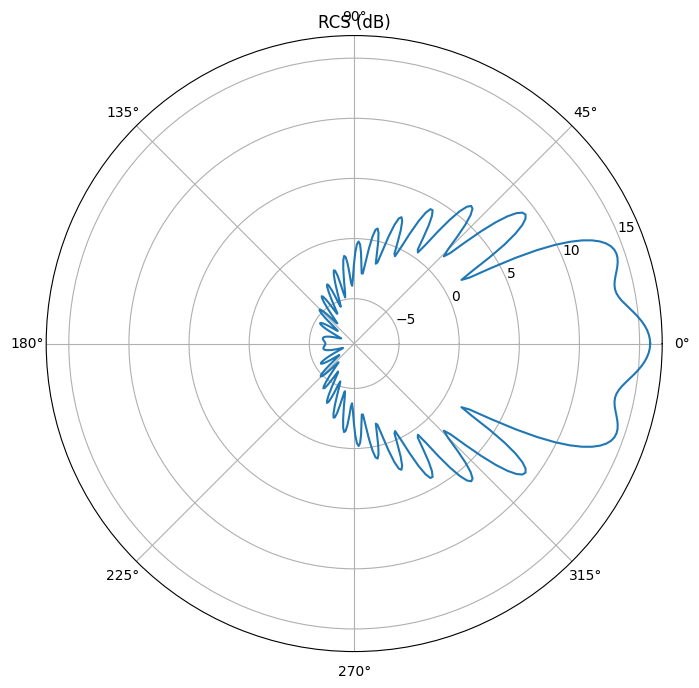

In [9]:
try:
    get_ipython().run_line_magic("matplotlib", "inline")
    ipython = True
except NameError:
    ipython = False
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 8))

plt.polar(theta, db_pattern)

plt.ylim(db_pattern.min() - 1, db_pattern.max() + 1)
plt.title("RCS (dB)")

if not ipython:
    plt.savefig("example-osrc_burton_miller.png")

## Further information

More information about the OSRC-preconditioned Burton-Miller formulation, including convergence plots and combination with fast matrix algebra, can be found in <a href='https://doi.org/10.1007/978-3-319-28832-1_9' target='new'>Betcke, van 't Wout & Gélat (2017)</a>.

The OSRC preconditioner can also be used to speed up acoustic BEM simulations for multiple and penetrable domains. Benchmark results for various boundary integral formulations are reported in <a href='https://doi.org/10.1002/nme.6777' target='new'>van 't Wout et al. (2021)</a>.
More information about the OSRC-preconditioned PMCHWT formulation, with application to focused ultrasound propagation in the human body, can be found in <a href='https://doi.org/10.1016/j.ultras.2020.106240' target='new'>Haqshenas et al. (2021)</a>.